In [1]:
! pip install -q pythainlp

     |████████████████████████████████| 11.0 MB 5.2 MB/s 
     |████████████████████████████████| 743 kB 24.5 MB/s 


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
import re
import string
from pythainlp.corpus.common import thai_stopwords

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocess Data

In [4]:
folder = '/content/drive/Shareddrives/wakaranai/Comments_Project/deepcut'
batch_size = 64
seed = 0

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    folder,
    # batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 574 files belonging to 2 classes.
Using 460 files for training.


In [5]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i].decode('UTF-8'))
    print("Label", label_batch.numpy()[i])

Review มึง เกิด ที่ ไหน ว่ะ
Label 0
Review ขอ ให้ ไป ตาย ใน คุก นะ คน ที่ ทำ
Label 1
Review @ ธัญเทพ เหลือง อร่าม จอมพล ปล้น อะไร จาก ราชวงศ์ ปล้น อะไร ประชาชน ที่ บอก คือ ไอดอล นี้ ของ ท่าน นี้ โจร ชั้น ยอด คน ที่ ตาย คน สุดท้าย ก็ ปี 55 ลูกหลาน คณะราษฎร รวย ทุก คน บังคับ ซื้อ ที่ดิน จาก ราชวงศ์ มัน ราคา หลัก ร้อย แถม ผ่อน อีก ที่ แต่ละ พื้น ทุก วัน นี้ หลัก พัน ล้าน หา ข้อมูล คณะราษฎร ที่ ท่าน ยก ยอ ด้วย ครับ วิกิพีเดีย ก็ มี ข้อมูล มา บังคับ ปล้น เอา จาก ราชวงศ์ ก็ เยอะ เน็ต ไม่ ได้ มี ไว้ ว่า ชาว บ้าน อย่าง เดียว ข้อมูล หา หลาย ๆ ด้าน อย่า รับ แต่ สื่อ ที่ ชอบ ครับ สื่อ พวก ท่าน ผม ก็ ดู ม๊อบ พวก ท่าน ผม ก็ ไป แล้ว ถึง กล้า พูด
Label 1


In [6]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to non-toxic
Label 1 corresponds to toxic


In [7]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    folder,
    # batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 574 files belonging to 2 classes.
Using 114 files for validation.


In [8]:
custom_stopwords = list(thai_stopwords()) + ['คน', 'ทำ', 'รุ่น', 'พี่', 'ตัว']
custom_stopwords.sort(key=lambda x: len(x), reverse=True)

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    strip = tf.strings.strip(lowercase)
    cut = tf.strings.regex_replace(strip, 'เหั้ย', 'เหี้ย')
    for i in ['งับ', 'คับ']:
        cut = tf.strings.regex_replace(cut, i, 'ครับ')
    # for i in custom_stopwords:
        # cut = tf.strings.regex_replace(cut, i, '')
    return tf.strings.regex_replace(cut,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [9]:
# max_features = 10000
# sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    # max_tokens=max_features,
    output_mode='int')
    # output_sequence_length=sequence_length)

In [10]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [11]:
vocab = vectorize_layer.get_vocabulary()
print(len(vocab))
print(sorted(vocab))

2415
['', '1', '10', '112', '113', '12', '15', '18', '2', '20', '2021', '2022', '23', '24', '2475', '2490', '2499', '250', '3', '30', '31', '4', '40', '44', '46', '48', '49', '5', '50', '53', '55', '555', '5555', '55555', '555555', '5555555555', '5555555555555', '6', '60', '62', '68', '7', '70', '8', '88', '90', '[UNK]', 'and', 'anti', 'antifa', 'antiroyalist', 'base', 'blm', 'by', 'conferrence', 'conquer', 'content', 'crablante', 'debate', 'divide', 'doctor', 'evidence', 'fact', 'gdp', 'gen', 'gg', 'harem', 'hee', 'hongmanee', 'jaruanphol', 'k', 'king', 'laws', 'liberal', 'logic', 'make', 'muentabutr', 'nijamphantho', 'ok', 'pdf', 'playbook', 'pragmatism', 'prefer', 'priority', 'pro', 'save', 'sense', 'slapp', 'social', 'sorry', 'sotus', 'subscribe', 'teng', 'transcript', 'usa', 'vedio', 'who', 'x', 'y', 'ก', 'กก', 'กกต', 'กฎ', 'กฎหมาย', 'กฏระเบียบ', 'กฏหมาย', 'กฐิน', 'กด', 'กดขี่', 'กติกา', 'กบฎ', 'กม', 'กรกฎาคม', 'กรณี', 'กรมราชทัณฑ์', 'กรรชัย', 'กรรม', 'กรรมการ', 'กรรมการกลั่นกรอง'

In [12]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [13]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review.numpy().decode('UTF-8'))
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label)[0].numpy())

Review ประหาร เถอะ ไอ้ พวก รุ่น พี่ กูโมโห มาก
Label toxic
Vectorized review [[ 231  215  317   28   55   85 2301   50]]


In [14]:
vectorize_text(first_review, first_label)[0].numpy()

array([[ 231,  215,  317,   28,   55,   85, 2301,   50]])

In [15]:
print(" 708 ---> ",vectorize_layer.get_vocabulary()[708])
print("  32 ---> ",vectorize_layer.get_vocabulary()[32])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

 708 --->  สูง
  32 --->  ผม
Vocabulary size: 2415


In [16]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# EDA

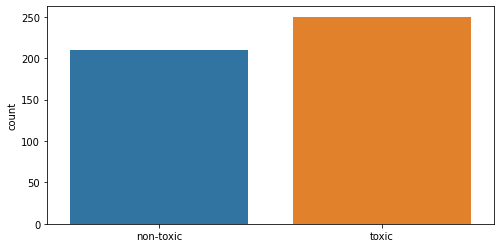

In [ ]:
labels = [y for x, y in train_ds.unbatch().as_numpy_iterator()]
labels = ['toxic' if i else 'non-toxic' for i in labels]
# print(labels)
plt.figure(figsize=(8, 4))
sns.countplot(x=labels, order=['non-toxic', 'toxic'])

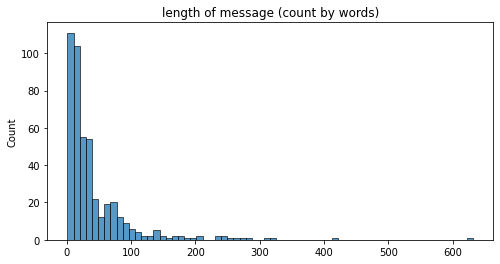

In [ ]:
length = [sum(x != 0) for x, y in train_ds.unbatch().as_numpy_iterator()]
# print(length)
plt.figure(figsize=(8, 4))
sns.histplot(x=length)
plt.title('length of message (count by words)')
plt.savefig('length.png')

# Model

In [ ]:
n_nontoxic = sum([1 for i in labels if i == 'non-toxic'])
n_toxic = sum([1 for i in labels if i == 'toxic'])
print(n_nontoxic)
print(n_toxic)
print(n_toxic / (n_nontoxic + n_toxic))
class_weight = {0: n_toxic / n_nontoxic, 1: n_nontoxic / n_toxic}
print(class_weight)

210
250
0.5434782608695652
{0: 1.1904761904761905, 1: 0.84}


## Word Embedding

In [18]:
embedding_dim = 5

model = tf.keras.Sequential([
  layers.Embedding(len(vectorize_layer.get_vocabulary()),
                   embedding_dim,),
#   layers.Dense(16, activation='relu'),
  layers.Dropout(0.2),
  layers.GlobalMaxPool1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 5)           12075     
                                                                 
 dropout (Dropout)           (None, None, 5)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 5)                0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 12,081
Trainable params: 12,081
Non-trainable params: 0
____________________________________________________

In [19]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [20]:
epochs = 400
checkpoint_path = 'cp.ckpt'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        monitor='val_binary_accuracy',
                                        save_weights_only=True,
                                        save_best_only=True,
                                        verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    # class_weight=class_weight,
    callbacks=[cp])

Epoch 1/400
15/15 [==============================] - ETA: 0s - loss: 0.6894 - binary_accuracy: 0.5391
Epoch 00001: val_binary_accuracy improved from -inf to 0.52632, saving model to cp.ckpt
15/15 [==============================] - 13s 708ms/step - loss: 0.6894 - binary_accuracy: 0.5391 - val_loss: 0.6921 - val_binary_accuracy: 0.5263
Epoch 2/400
14/15 [===========================>..] - ETA: 0s - loss: 0.6908 - binary_accuracy: 0.5402
Epoch 00002: val_binary_accuracy did not improve from 0.52632
15/15 [==============================] - 0s 14ms/step - loss: 0.6907 - binary_accuracy: 0.5435 - val_loss: 0.6918 - val_binary_accuracy: 0.5263
Epoch 3/400
12/15 [=======================>......] - ETA: 0s - loss: 0.6895 - binary_accuracy: 0.5469
Epoch 00003: val_binary_accuracy did not improve from 0.52632
15/15 [==============================] - 0s 18ms/step - loss: 0.6887 - binary_accuracy: 0.5500 - val_loss: 0.6914 - val_binary_accuracy: 0.5263
Epoch 4/400
15/15 [=============================

## Word Embedding loss & accuracy

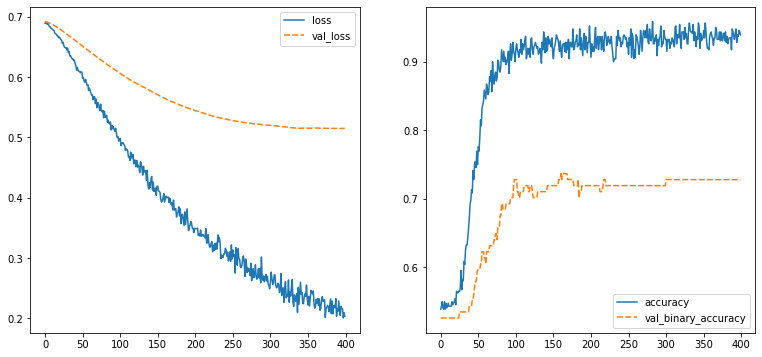

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

sns.lineplot(data={'loss': loss, 'val_loss': val_loss}, ax=axes[0])
sns.lineplot(data={'accuracy': acc, 'val_binary_accuracy': val_acc}, ax=axes[1])
plt.savefig('embedded_plt.png')

## Word Embedding Confusion Matrix

In [22]:
import numpy as np
from sklearn.metrics import classification_report

model.load_weights(checkpoint_path)
predictions = np.array([])
true =  np.array([])

for x, y in val_ds:
  temp = model.predict(x)
  predictions = np.concatenate([predictions, (temp.reshape(temp.shape[0]) > 0) * 1])
  true = np.concatenate([true, y.numpy()])

print(classification_report(true, predictions, target_names=raw_val_ds.class_names, digits=4))

              precision    recall  f1-score   support

   non-toxic     0.7308    0.7037    0.7170        54
       toxic     0.7419    0.7667    0.7541        60

    accuracy                         0.7368       114
   macro avg     0.7364    0.7352    0.7355       114
weighted avg     0.7366    0.7368    0.7365       114



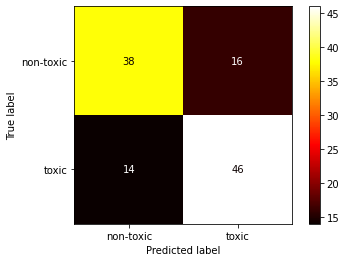

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=raw_val_ds.class_names)
disp.plot(cmap='hot')
plt.savefig('confusionmatrix.png')
plt.show()

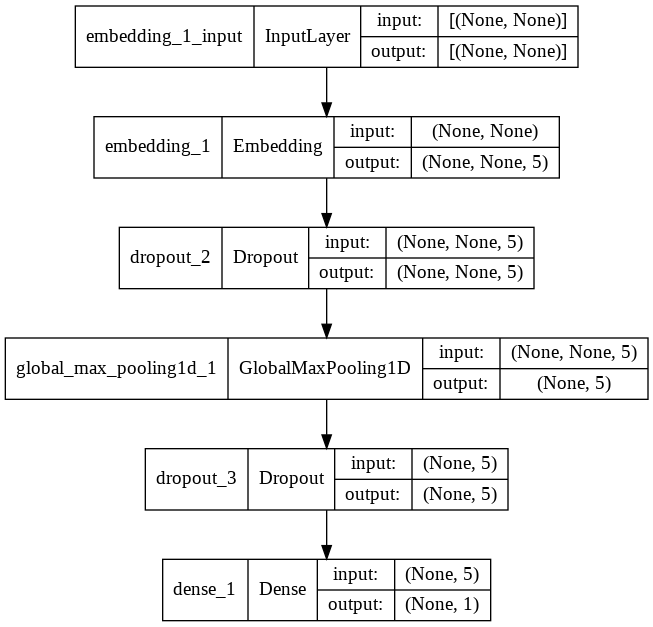

In [ ]:
tf.keras.utils.plot_model(model,
                          to_file='embedding.png',
                          show_shapes=True,
                          show_layer_names=True)

## LSTM

In [25]:
model = tf.keras.Sequential([
    layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    layers.Bidirectional(tf.keras.layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          154560    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 228,929
Trainable params: 228,929
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [28]:
epochs = 100
cp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        save_weights_only=True,
                                        save_best_only=True,
                                        verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[cp]
)

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.4565
Epoch 00001: val_loss improved from inf to 0.69270, saving model to cp.ckpt
15/15 [==============================] - 18s 325ms/step - loss: 0.6931 - accuracy: 0.4565 - val_loss: 0.6927 - val_accuracy: 0.4737
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.4565
Epoch 00002: val_loss improved from 0.69270 to 0.69214, saving model to cp.ckpt
15/15 [==============================] - 2s 113ms/step - loss: 0.6916 - accuracy: 0.4565 - val_loss: 0.6921 - val_accuracy: 0.4737
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.4565
Epoch 00003: val_loss improved from 0.69214 to 0.69153, saving model to cp.ckpt
15/15 [==============================] - 2s 114ms/step - loss: 0.6902 - accuracy: 0.4565 - val_loss: 0.6915 - val_accuracy: 0.4737
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.6884 - accurac

## LSTM loss & accuracy

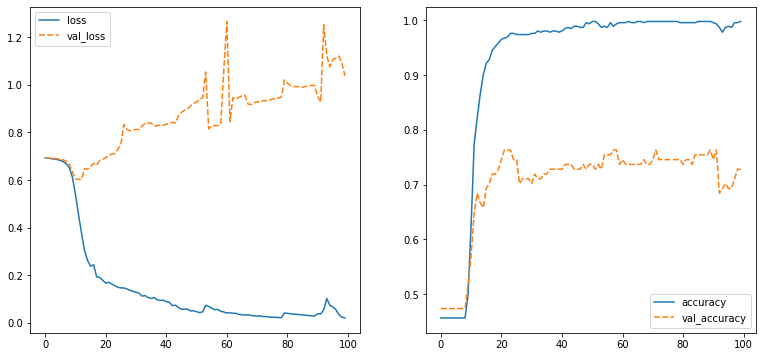

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

sns.lineplot(data={'loss': loss, 'val_loss': val_loss}, ax=axes[0])
sns.lineplot(data={'accuracy': acc, 'val_accuracy': val_acc}, ax=axes[1])

## LSTM Confusion Matrix

In [30]:
import numpy as np
from sklearn.metrics import classification_report

model.load_weights(checkpoint_path)
predictions = np.array([])
true =  np.array([])

for x, y in val_ds:
  temp = model.predict(x)
  predictions = np.concatenate([predictions, (temp.reshape(temp.shape[0]) > 0) * 1])
  true = np.concatenate([true, y.numpy()])

print(classification_report(true, predictions, target_names=raw_val_ds.class_names, digits=4))

              precision    recall  f1-score   support

   non-toxic     0.7344    0.8704    0.7966        54
       toxic     0.8600    0.7167    0.7818        60

    accuracy                         0.7895       114
   macro avg     0.7972    0.7935    0.7892       114
weighted avg     0.8005    0.7895    0.7888       114



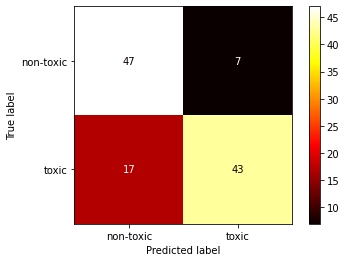

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=raw_val_ds.class_names)
disp.plot(cmap='hot')
plt.savefig('confusionmatrix.png')
plt.show()

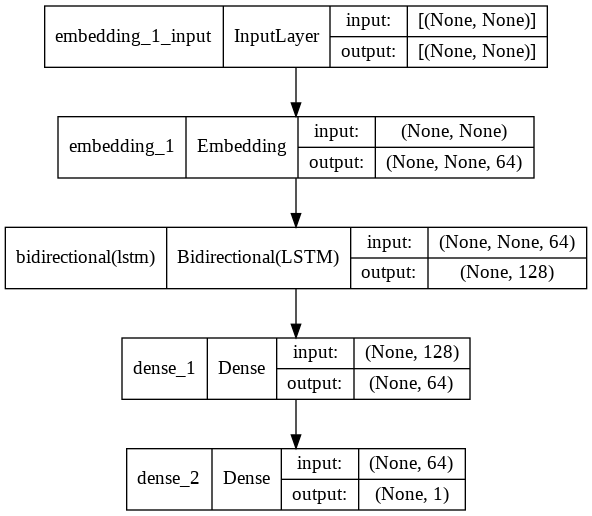

In [32]:
tf.keras.utils.plot_model(model,
                          to_file='embedding.png',
                          show_shapes=True,
                          show_layer_names=True)

## 2 LSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          154560    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
epochs = 100
cp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        save_weights_only=True,
                                        save_best_only=True,
                                        verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weight,
    callbacks=[cp])

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4565
Epoch 00001: val_loss improved from inf to 0.69281, saving model to cp.ckpt
15/15 [==============================] - 27s 694ms/step - loss: 0.6934 - accuracy: 0.4565 - val_loss: 0.6928 - val_accuracy: 0.4737
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.4565
Epoch 00002: val_loss improved from 0.69281 to 0.69271, saving model to cp.ckpt
15/15 [==============================] - 3s 217ms/step - loss: 0.6925 - accuracy: 0.4565 - val_loss: 0.6927 - val_accuracy: 0.4737
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.4565
Epoch 00003: val_loss improved from 0.69271 to 0.69245, saving model to cp.ckpt
15/15 [==============================] - 3s 217ms/step - loss: 0.6909 - accuracy: 0.4565 - val_loss: 0.6924 - val_accuracy: 0.4737
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.6898 - accurac

## 2 LSTM loss & accuracy

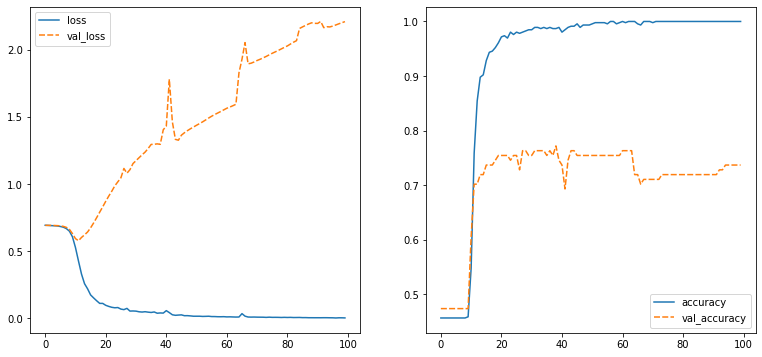

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

sns.lineplot(data={'loss': loss, 'val_loss': val_loss}, ax=axes[0])
sns.lineplot(data={'accuracy': acc, 'val_accuracy': val_acc}, ax=axes[1])

## 2 LSTM Confusion Matrix

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

model.load_weights(checkpoint_path)
predictions = np.array([])
true =  np.array([])

for x, y in val_ds:
  temp = model.predict(x)
  predictions = np.concatenate([predictions, (temp.reshape(temp.shape[0]) > 0) * 1])
  true = np.concatenate([true, y.numpy()])

print(classification_report(true, predictions, target_names=raw_val_ds.class_names, digits=4))

              precision    recall  f1-score   support

   non-toxic     0.7170    0.7037    0.7103        54
       toxic     0.7377    0.7500    0.7438        60

    accuracy                         0.7281       114
   macro avg     0.7273    0.7269    0.7270       114
weighted avg     0.7279    0.7281    0.7279       114



## Other model